### 사전 준비

In [3]:
!pip uninstall -y lightgbm
!apt-get install -y libboost-all-dev
!git clone --recursive https://github.com/Microsoft/LightGBM

%cd /content/LightGBM

!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package/
!sudo python setup.py install --precompile

!cd LightGBM/python-package/;python setup.py install --precompile

Found existing installation: lightgbm 3.3.5
Uninstalling lightgbm-3.3.5:
  Successfully uninstalled lightgbm-3.3.5
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-all-dev is already the newest version (1.71.0.0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM
mkdir: cannot create directory ‘build’: File exists
CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


-- OpenCL include directory: /usr/include
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM
Consolidate compiler generated dependencies of target lightgbm_capi_objs
[  1%] Built target lightgbm_capi_objs
Conso

In [6]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import math
import lightgbm as lgb

### 데이터 불러오기

In [31]:
# 데이터 불러오기

def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

csv_to_parquet('train.csv', 'train')
csv_to_parquet('test.csv', 'test')
csv_to_parquet('sample_submission.csv', 'sample_submission')

train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')
sample_submission = pd.read_parquet('sample_submission.parquet')

train Done.
test Done.
sample_submission Done.


### 데이터 시각화, 엔지니어링, 전처리

In [32]:
str_col = ['day_of_week','start_turn_restricted','end_turn_restricted']

for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [33]:
# %Y%m%d 형식이었던 시간 데이터를 월, 일로 나눔

train = train.astype({'base_date' : 'str'})

train['month'] = train['base_date'].str.slice(4, 6).astype(np.int64)
train['day'] = train['base_date'].str.slice(6, 8).astype(np.int64)

test = test.astype({'base_date' : 'str'})

test['month'] = test['base_date'].str.slice(4, 6).astype(np.int64)
test['day'] = test['base_date'].str.slice(6, 8).astype(np.int64)

# 시작 지점과 도착 지점의 직선거리 피처 생성

train['distance'] = np.sqrt((train['end_longitude'] - train['start_longitude']) ** 2 + (train['end_latitude'] - train['start_latitude']) ** 2)
train = train.drop(['base_date'], axis = 1)

test['distance'] = np.sqrt((test['end_longitude'] - test['start_longitude']) ** 2 + (test['end_latitude'] - test['start_latitude']) ** 2)
test = test.drop(['base_date'], axis = 1)

In [34]:
# 타겟값 구간 분할

def target_cut(x):
    if x <= 20:
        return 1
    elif x > 20 and x <= 40:
        return 2
    elif x > 40 and x <= 60:
        return 3
    elif x > 60 and x <= 80:
        return 4
    elif x > 80 and x <= 100:
        return 5
    else:
        return 6
        
train['target_cut'] = train['target'].apply(target_cut) 

In [35]:
# 범주형 피처와 연속형 피처 나눔

categorical_cols = train[['multi_linked', 'connect_code', 'day_of_week', 'road_rating', 'start_turn_restricted',
                          'end_turn_restricted', 'target']]

continuous_cols = train[['month', 'day', 'base_hour', 'lane_count', 'maximum_speed_limit', 'weight_restricted',
                         'height_restricted', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'distance',
                         'target_cut']]

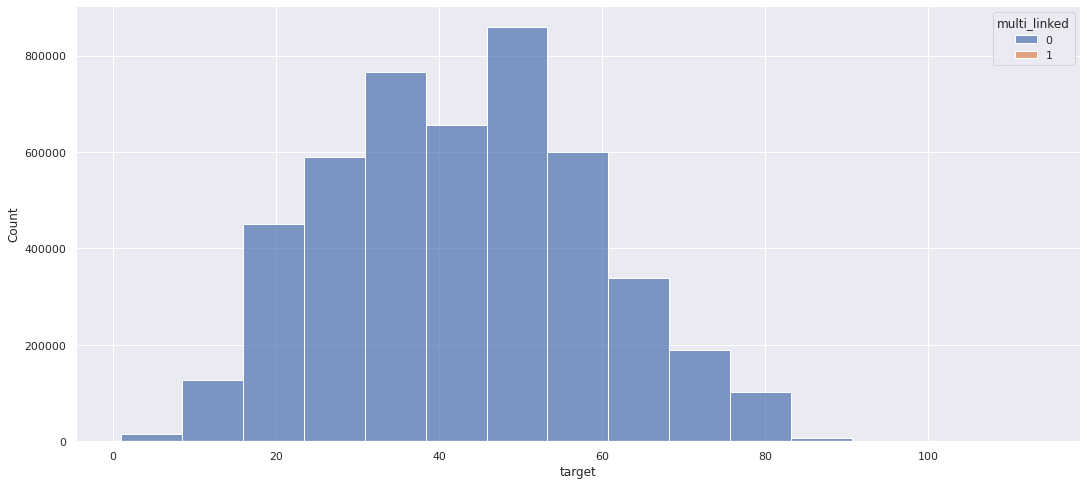

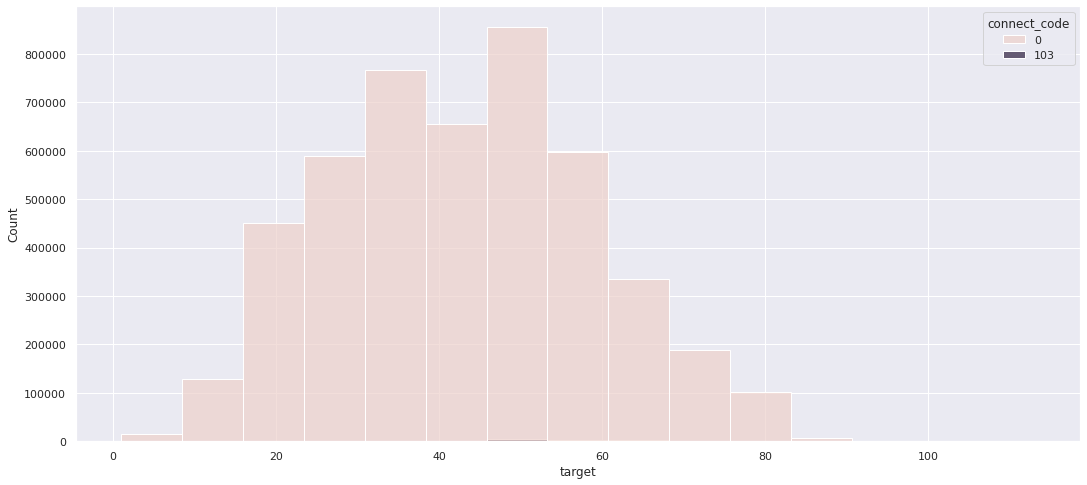

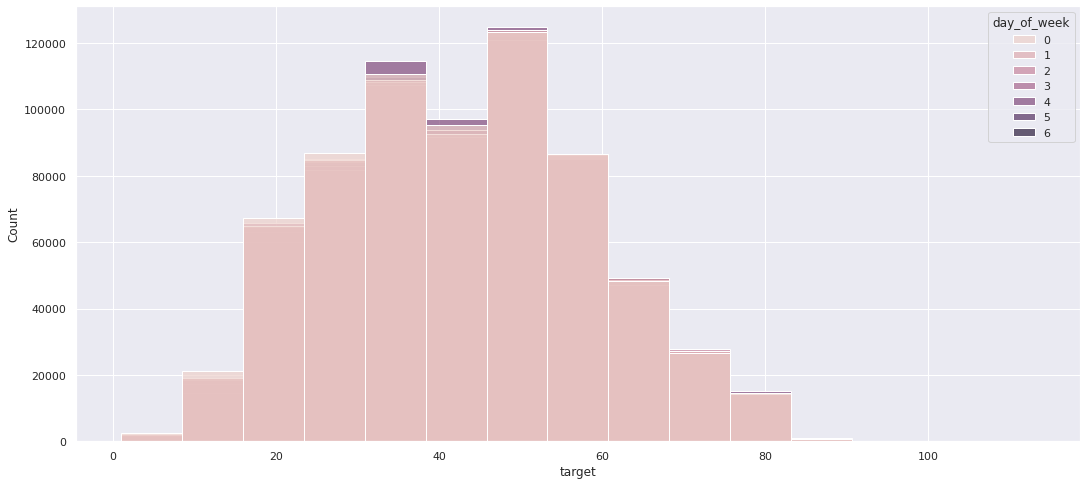

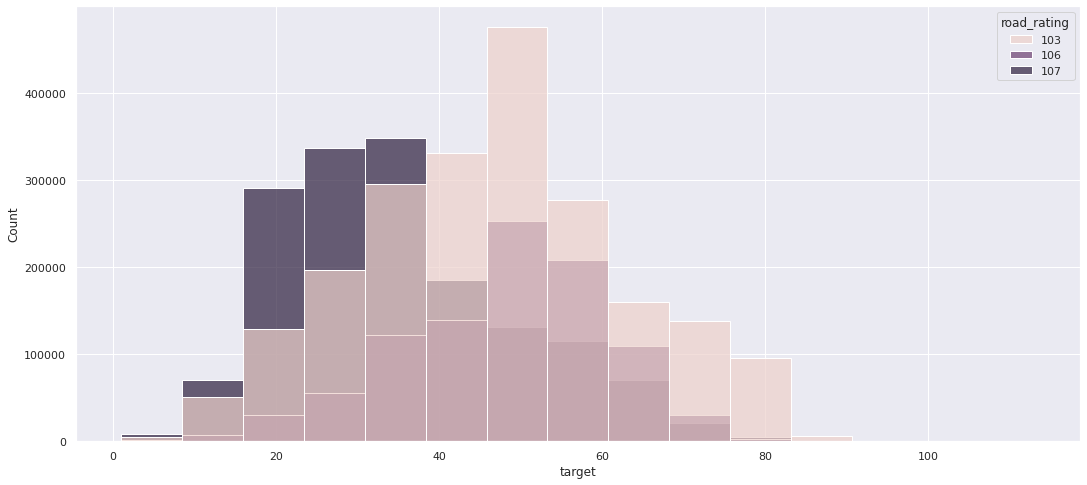

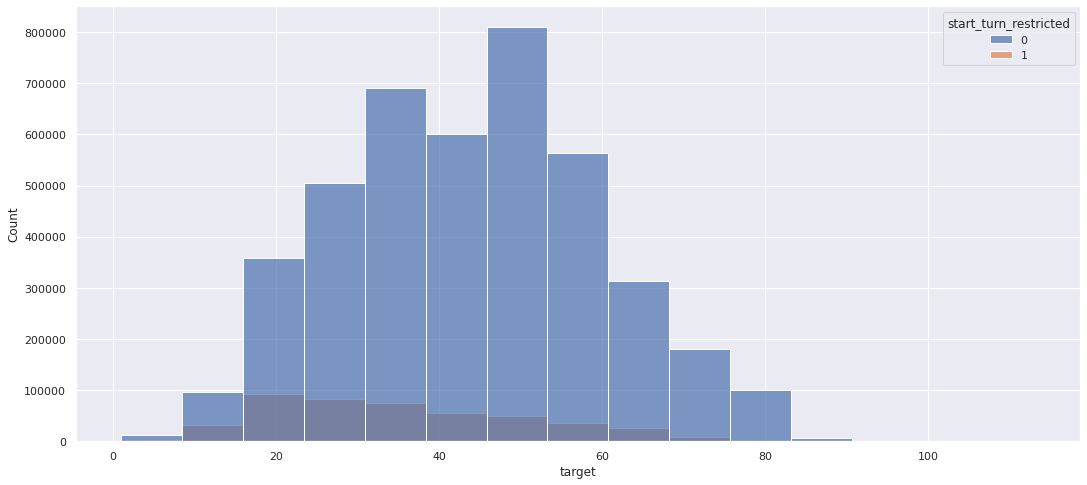

In [36]:
sns.set(rc={'figure.figsize':(18,8)})

for i in categorical_cols.columns[:-2]:
    sns.histplot(data=categorical_cols, x = "target", alpha = .7, bins = 15, hue = i)
    plt.show()

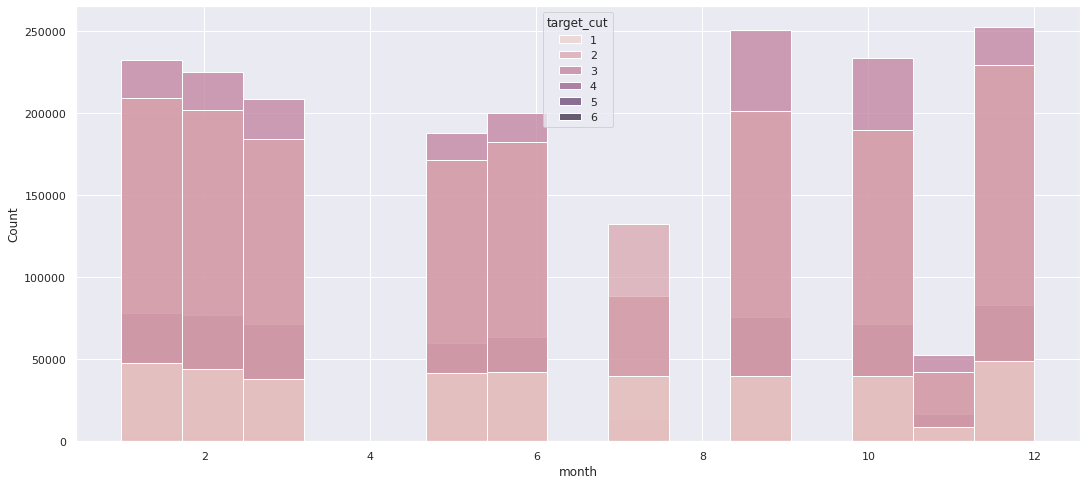

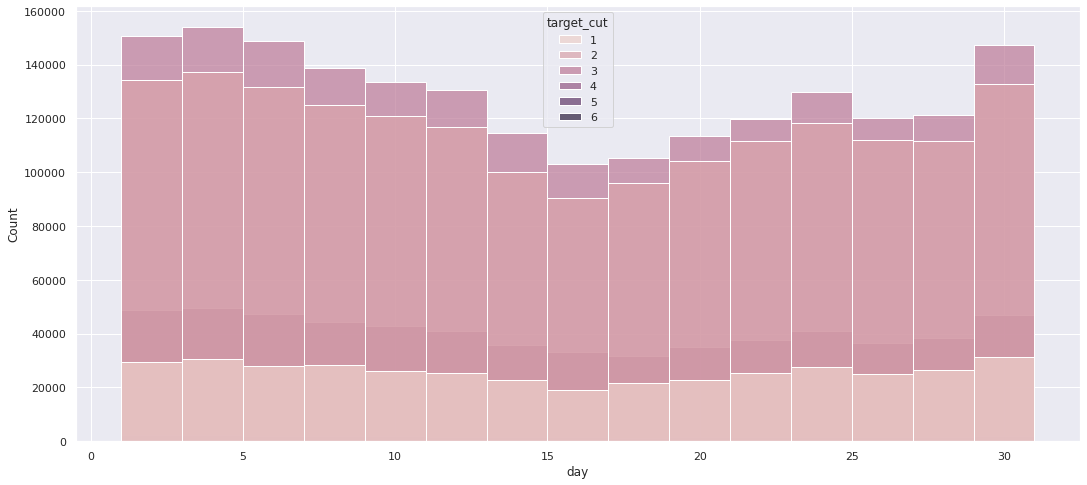

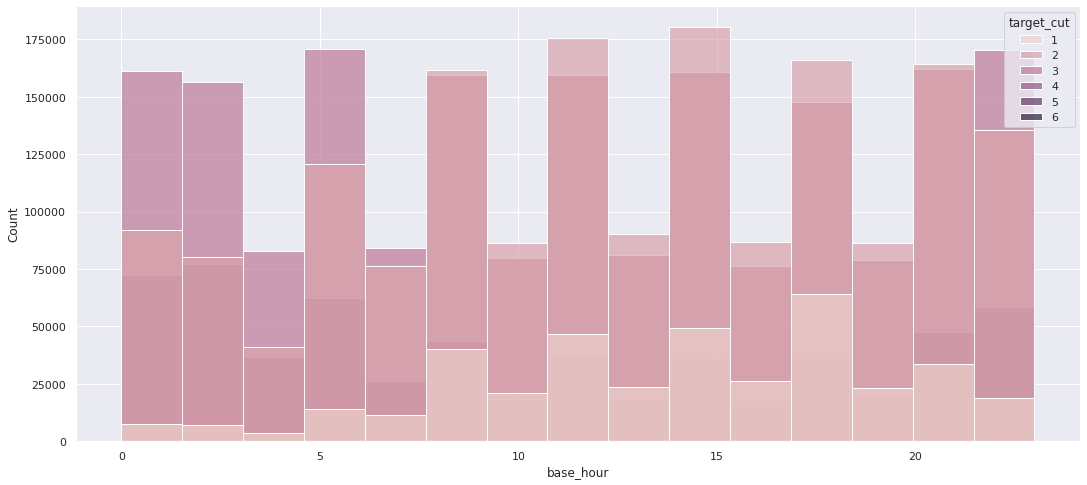

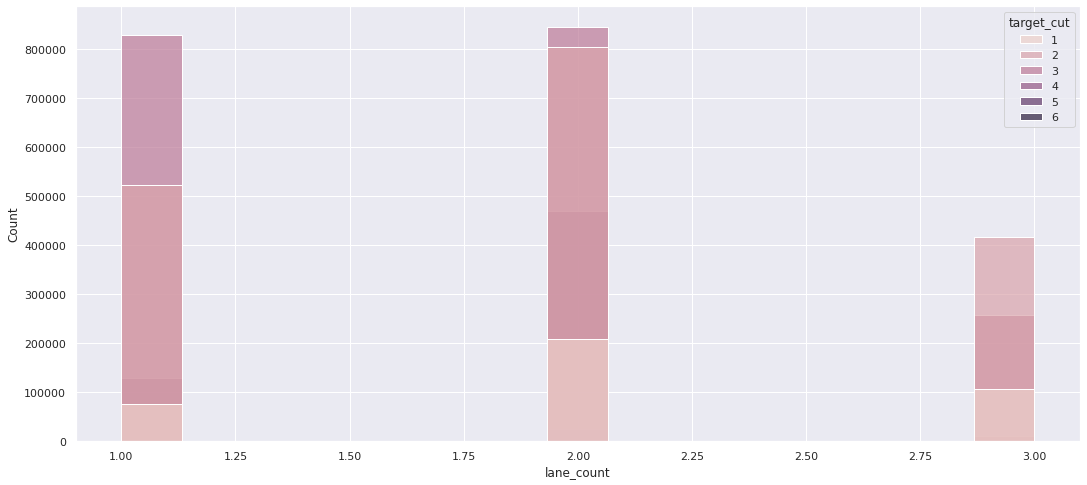

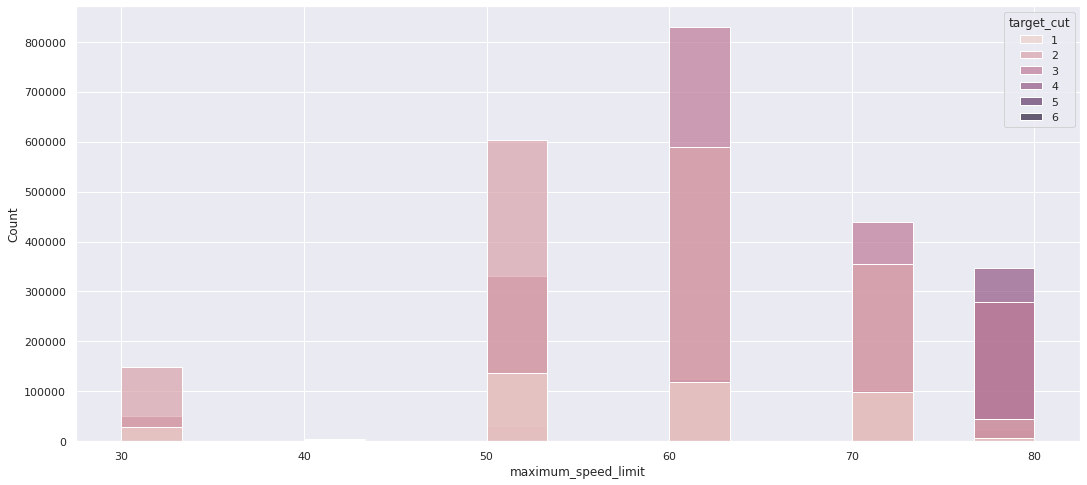

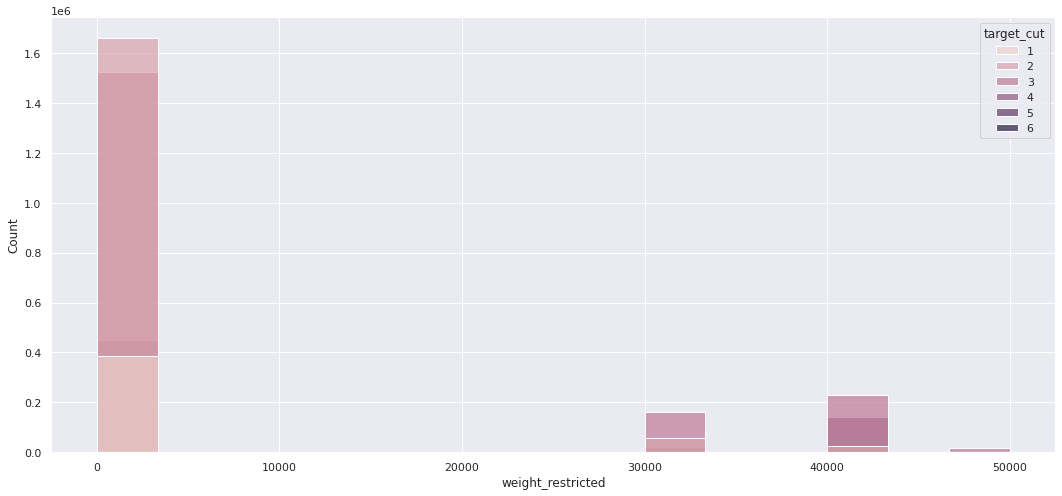

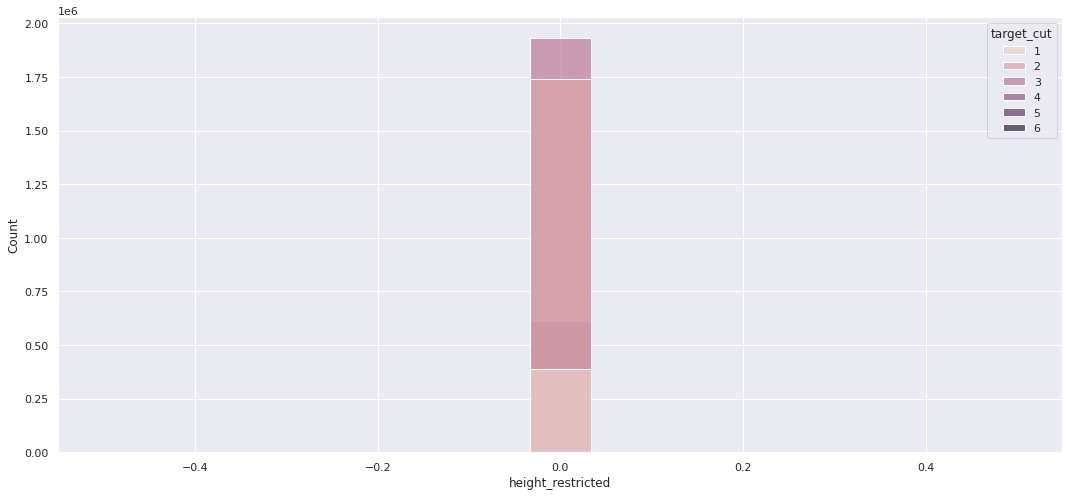

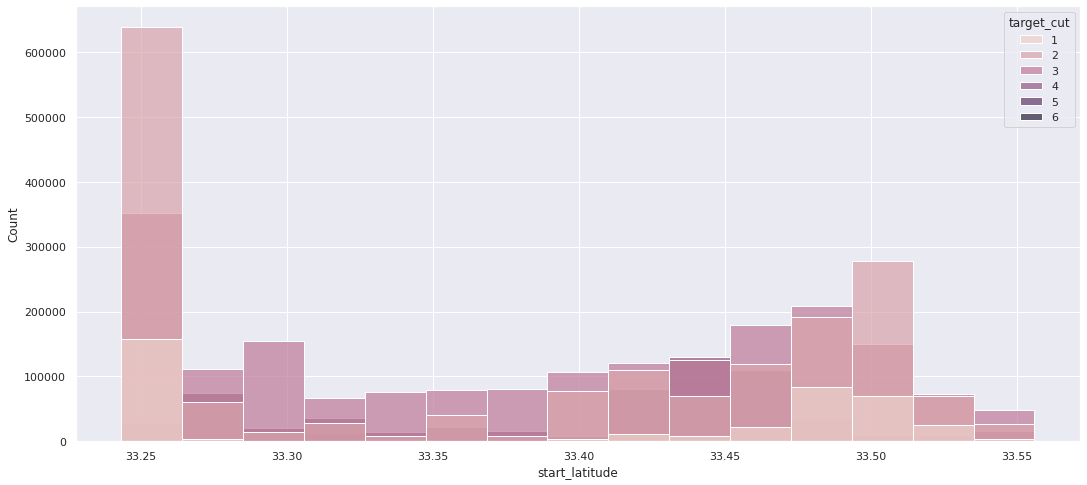

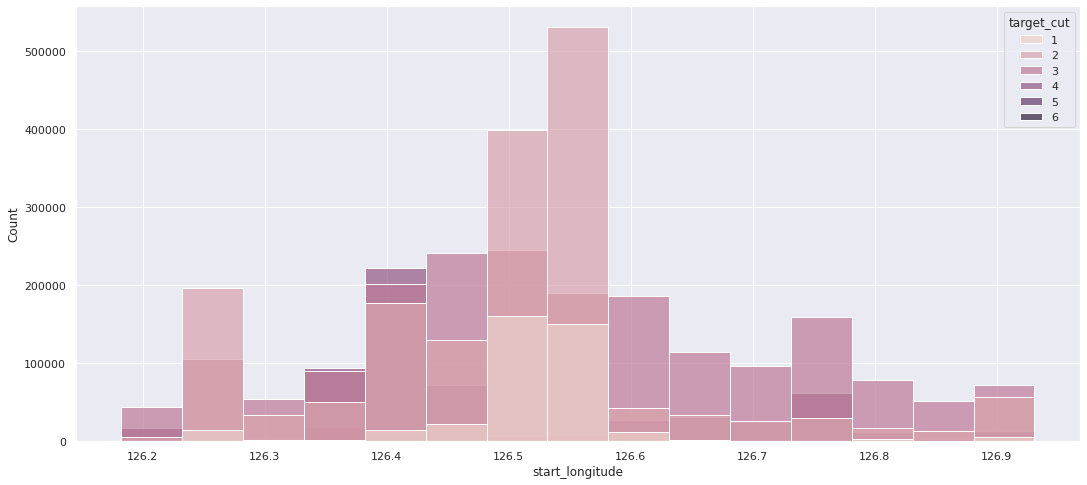

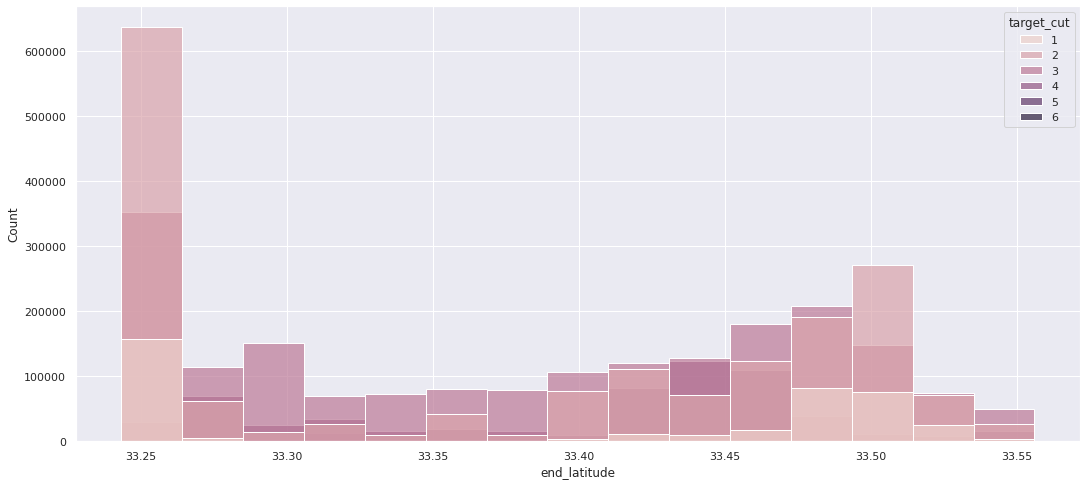

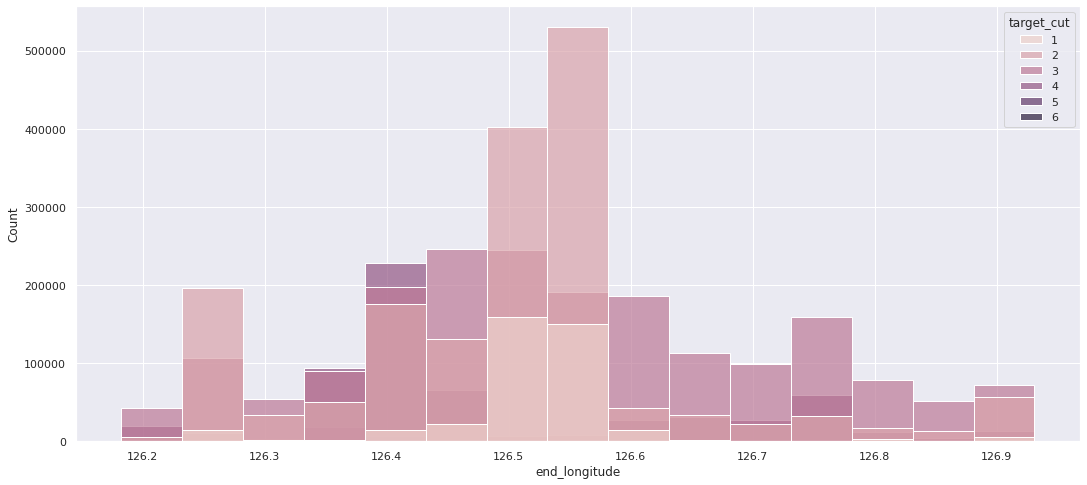

In [37]:
sns.set(rc={'figure.figsize':(18,8)})

for i in continuous_cols.columns[:-2]:
    sns.histplot(data=continuous_cols, x = i, alpha = .7, bins = 15, hue = 'target_cut')
    plt.show()

In [38]:
test = test[['month', 'day', 'base_hour', 'lane_count', 'road_rating', 'multi_linked', 'connect_code', 
             'maximum_speed_limit', 'weight_restricted', 'height_restricted', 'start_latitude', 'start_longitude',
             'end_latitude', 'end_longitude', 'distance', 'day_of_week', 'start_turn_restricted','end_turn_restricted']]

train = train[['month', 'day', 'base_hour', 'lane_count', 'road_rating', 'multi_linked', 'connect_code', 
               'maximum_speed_limit', 'weight_restricted', 'height_restricted', 'start_latitude', 'start_longitude',
               'end_latitude', 'end_longitude', 'distance','day_of_week', 'start_turn_restricted','end_turn_restricted', 'target']]

In [40]:
useful_cols = ['day_of_week', 'start_turn_restricted', 'end_turn_restricted', 'month', 'base_hour',
               'lane_count', 'road_rating', 'maximum_speed_limit', 'weight_restricted',
               'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 'distance']

In [41]:
train = train[useful_cols + ['target']]
test = test[useful_cols]

### 모델링

In [42]:
# 학습 데이터를 준비하고 구조 확인

from sklearn.model_selection import train_test_split

y_train = train['target'] 

X_train = train.drop(['target'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42, shuffle = True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42, shuffle = True)
# 자체적으로 스코어 측정하기 위한 테스트 데이터셋

print(train.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
print(test.shape)

(4701217, 15)
(3290851, 14)
(3290851,)
(705183, 14)
(705183,)
(705183, 14)
(705183,)
(291241, 14)


In [45]:
from sklearn.model_selection import GridSearchCV

LR = lgb.LGBMRegressor(random_state=42, n_estimators=100, bagging_fraction = 0.7, device = "gpu", verbose = -1)

grid_parameters = {"num_leaves" : [1000, 1250, 1500],
                   "learning_rate": [0.1, 0.01]}

grid_model = GridSearchCV(LR, param_grid = grid_parameters, cv = 3, refit = True, verbose = 2)

grid_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= "mae")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .................learning_rate=0.1, num_leaves=1000; total time= 1.2min
[CV] END .................learning_rate=0.1, num_leaves=1000; total time= 1.1min
[CV] END .................learning_rate=0.1, num_leaves=1000; total time= 1.1min
[CV] END .................learning_rate=0.1, num_leaves=1250; total time= 1.2min
[CV] END .................learning_rate=0.1, num_leaves=1250; total time= 1.3min
[CV] END .................learning_rate=0.1, num_leaves=1250; total time= 1.2min
[CV] END .................learning_rate=0.1, num_leaves=1500; total time= 1.3min
[CV] END .................learning_rate=0.1, num_leaves=1500; total time= 1.4min
[CV] END .................learning_rate=0.1, num_leaves=1500; total time= 1.3min
[CV] END ................learning_rate=0.01, num_leaves=1000; total time= 1.4min
[CV] END ................learning_rate=0.01, num_leaves=1000; total time= 1.3min
[CV] END ................learning_rate=0.01, num_

GridSearchCV(cv=3,
             estimator=LGBMRegressor(bagging_fraction=0.7, device='gpu',
                                     random_state=42, verbose=-1),
             param_grid={'learning_rate': [0.1, 0.01],
                         'num_leaves': [1000, 1250, 1500]},
             verbose=2)

In [46]:
print('best_params_: ', grid_model.best_params_)
print('best_estimator_: ', grid_model.best_estimator_)
print('best_score_: {:.4f}'.format(grid_model.best_score_))

best_model = grid_model.best_estimator_

best_params_:  {'learning_rate': 0.1, 'num_leaves': 1500}
best_estimator_:  LGBMRegressor(bagging_fraction=0.7, device='gpu', num_leaves=1500,
              random_state=42, verbose=-1)
best_score_: 0.9187


In [48]:
from sklearn.metrics import mean_absolute_error
y_pred = best_model.predict(X_test, verbose = -1)
mean_absolute_error(y_test, y_pred) 

3.147297708993342

In [49]:
y_train = train['target'] 
X_train = train.drop(['target'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, shuffle = True)

print(train.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(test.shape)

(4701217, 15)
(3760973, 14)
(3760973,)
(940244, 14)
(940244,)
(291241, 14)


In [50]:
final_model = lgb.LGBMRegressor(random_state=42,
                                bagging_fraction = 0.7,
                                learning_rate = 0.1,
                                verbose = -1,
                                num_leaves = 1500,
                                n_estimators = 2500,
                                device = "gpu",
                                early_stopping_rounds=10)


final_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= "mae")

LGBMRegressor(bagging_fraction=0.7, device='gpu', early_stopping_rounds=10,
              n_estimators=2500, num_leaves=1500, random_state=42, verbose=-1)

In [51]:
y_train = train['target'] 
X_train = train.drop(['target'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42, shuffle = True)

print(train.shape)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(test.shape)

(4701217, 15)
(3760973, 14)
(3760973,)
(940244, 14)
(940244,)
(291241, 14)


In [52]:
y_predict = final_model.predict(test)

In [53]:
sample_submission['target'] = y_predict
sample_submission.to_csv("lgbm_gridsearch_3.csv", index = False)

In [54]:
sample_submission

,id,target
0,TEST_000000,25.423519
1,TEST_000001,43.334492
2,TEST_000002,66.894221
3,TEST_000003,37.712059
4,TEST_000004,43.184059
...,...,...
291236,TEST_291236,47.162218
291237,TEST_291237,51.820426
291238,TEST_291238,22.387478
291239,TEST_291239,22.565280


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

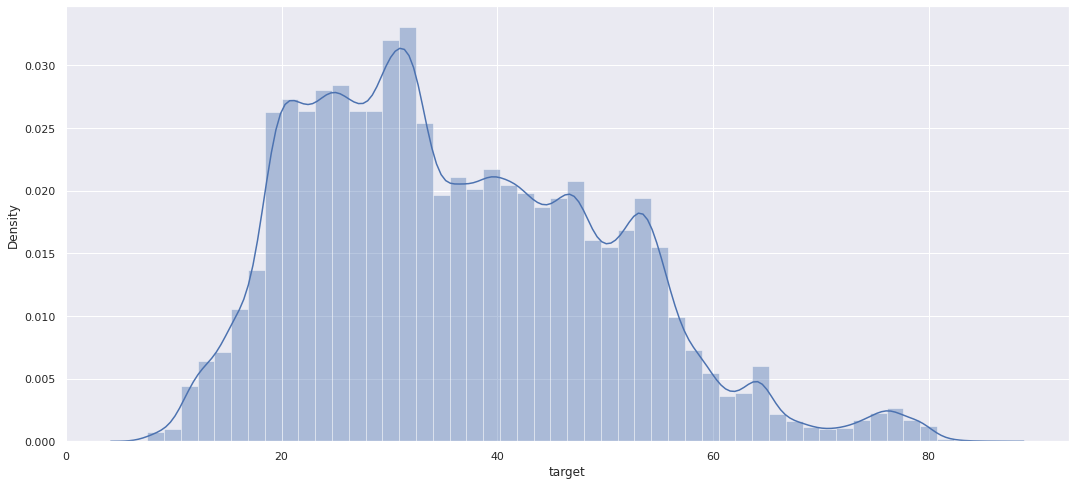

In [55]:
sns.distplot(sample_submission.target) 